In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [ ]:
using Pkg

Pkg.add(Pkg.PackageSpec(;name="CuArrays", version=v"1.3.0"))
Pkg.add(Pkg.PackageSpec(;name="Flux", version=v"0.9.0"))

pkg"add ImageMagick"
pkg"add Images"
pkg"add Plots"

pkg"precompile"

using Base.Iterators: partition

using CuArrays
using Flux
using Flux: @epochs, crossentropy, onehotbatch
using Flux.Data.MNIST
using Images

# Housekeeping #

## Remote lecture ##

This is far from ideal, sorry, here I am live from Saitama (just north of Tokyo), Japan from a baby nursery. Some things to keep in mind:

1. I can most likely not hear you, thus you will have to “speak through” Pasquale – a researcher in my team and TA for the module – who is present at the lecture.

2. I can also most likely not see you, this is extremely awkward, expect some odd pacing.

3. Although I spent about an hour yesterday stabilising the WiFi connection, it could go flaky. Do stay put, I have built some slack into the lecture to ensure that we get through even if we lose time in the middle.

## Assignment 1 ##

1. Marking almost done, apologies for the delays.

2. Overall, I am very very impressed. Many of you are above 90 and it is well deserved.

3. But… pretty please, do not hand in hundreds of pages with printouts. Try to cut out what is not relevant, especially, we really can not read your weight matrices.

## Assignment 2 ##

1. I have heard rumours about issues with slowdowns on Colaboratory, is this still the case and how many are affected?

2. For those with questions in my inbox, I hope to get around to them shortly after this lecture.

3. Can you comment on the difficulty of Assignment 2? Just right? Too difficult? Too easy? In terms of effort? Too much? Too little?

## Assignment 3 ##

1. To be finalised and distributed tomorrow (Friday), awaiting last adjustments based on your feedback on Assignment 2.

2. Timetabling has still not gotten back to me about additional tutorials in January, how about we run a tutorial (support) session at the UCL Centre for Artificial Intelligence from 15:00 to 18:00 on January 13th akin to what we did last week? My impression was that one-on-one help was very much appreciated by the students. It also gives you time before that Friday (January 17th) when the assignment is due.



# A concrete realisation of a convolutional neural network #

A very short lecture (no, **really**!) but I need *you* for the latter part.

## Recap (this time I will not mess up…) ##

![](https://cdn-images-1.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)

[Image source](https://cdn-images-1.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)

### Filters or feature detectors ###

![](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-5.15.35-PM.png)

[Image source](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-5.15.35-PM.png)

![](https://www.jeremyjordan.me/content/images/2017/08/Screen-Shot-2017-08-23-at-5.05.59-PM.png)

[Image source](https://www.jeremyjordan.me/content/images/2017/08/Screen-Shot-2017-08-23-at-5.05.59-PM.png)

![](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-6.13.41-PM.png)

[Image source](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-6.13.41-PM.png)

![](https://www.jeremyjordan.me/content/images/2017/07/no_padding_no_strides.gif)

[Image source](https://github.com/vdumoulin/conv_arithmetic)

![](https://www.jeremyjordan.me/content/images/2017/07/same_padding_no_strides.gif)

[Image source](https://github.com/vdumoulin/conv_arithmetic)

## Pooling or “subsampling” ##

![](http://www.embedded-vision.com/sites/default/files/technical-articles/CadenceCNN/Figure7.jpg)

[Image source](http://www.embedded-vision.com/sites/default/files/technical-articles/CadenceCNN/Figure7.jpg)

## A concrete implementation ##

In [ ]:
images = [MNIST.images(:train); MNIST.images(:test)]
labels = [MNIST.labels(:train); MNIST.labels(:test)]

trainimages = images[1:50_000]
trainlabels = labels[1:50_000]
validimages = images[50_001:60_000]
validlabels = labels[50_001:60_000]
testimages  = images[60_001:70_000]
testlabels  = labels[60_001:70_000]

@assert length(trainimages) + length(validimages) + length(testimages) == length(images)
@assert length(trainlabels) + length(validlabels) + length(testlabels) == length(labels)

# If necessary, we can downsample for increased training speed as we experiment.
downfactor  = 1
trainimages = trainimages[1:div(end, downfactor)]
trainlabels = trainlabels[1:div(end, downfactor)]
validimages = validimages[1:div(end, downfactor)]
validlabels = validlabels[1:div(end, downfactor)]
testimages  = testimages[1:div(end, downfactor)]
testlabels  = testlabels[1:div(end, downfactor)]

nothing

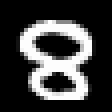

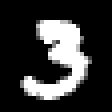

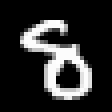

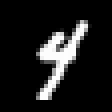

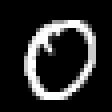

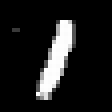

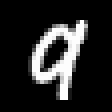

In [ ]:
for _ in 1:7
    display(trainimages[rand(1:end)])
end

In [ ]:
function minibatch(xs, ys, idxs)
    xsbatch = Array{Float32}(undef, size(first(xs))..., 1, length(idxs))
    for i in 1:length(idxs)
        xsbatch[:, :, :, i] = Float32.(xs[idxs[i]])
    end
    ysbatch = onehotbatch(ys[idxs], 0:9)
    xsbatch, ysbatch
end

batchsz        = 128
trainbatchidxs = partition(1:length(trainimages), batchsz)
# Note how we send each batch to the GPU here, not the vector of batches.
trainset       = [minibatch(trainimages, trainlabels, i) |> gpu for i in trainbatchidxs]
validset       = minibatch(validimages, validlabels, 1:length(validimages)) |> gpu
testset        = minibatch(testimages, testlabels, 1:length(testimages)) |> gpu

nothing

In [ ]:
model = Chain(
        # 28x28 input, with 3x3 filters and padding.
        Conv((3, 3), 1=>16, pad=(1, 1), relu),
        MaxPool((2, 2)),
        # 14x14 input, with 3x3 filters and padding.
        Conv((3, 3), 16=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        # 7x7 input, with 3x3 filters and padding.
        Conv((3, 3), 32=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(288, 10),
        softmax,
    ) |> gpu

loss(x, y)     = crossentropy(model(x), y)
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
# Was unstable at 0.01
optimiser      = ADAM(0.001)

nothing

In [ ]:
@time for epoch in 1:64
    Flux.train!(loss, params(model), trainset, optimiser)
    # Note the `data`, as it immediately releases memory from the computation graph.
    println("$(epoch)\t$(loss(trainset[1]...).data)\t$(loss(validset...).data)")
    flush(stdout)
end

1	0.16313139	0.12735628
2	0.12272546	0.08272201
3	0.104264334	0.06648715
4	0.095422596	0.06055332
5	0.07790225	0.056608185
6	0.05847622	0.053593084
7	0.05078628	0.05245751
8	0.03885486	0.053834107
9	0.031950995	0.054836173
10	0.02681949	0.055465367
11	0.031100022	0.0601554
12	0.02506641	0.059415836
13	0.030933036	0.057616416
14	0.028755896	0.059131473
15	0.018903868	0.05691527
16	0.008003635	0.05790382
17	0.012712722	0.06244962
18	0.0022608165	0.06260715
19	0.003360372	0.06481793
20	0.002072381	0.066803426
21	0.0015135683	0.06622594
22	0.0049500526	0.0677051
23	0.0040671444	0.07219991
24	0.002389573	0.08000021
25	0.0026949826	0.069146976
26	0.00056079956	0.080129676
27	0.00093512743	0.07554482
28	0.00095638697	0.08976978
29	0.00040733302	0.074409425
30	0.0011180572	0.07966133
31	0.004424322	0.07644962
32	0.0015254047	0.08404951
33	0.0010782778	0.07958546
34	0.00030691898	0.072719656
35	0.026674183	0.07989778
36	0.00041256333	0.0759737
37	0.0040519964	0.09482984
38	0.000757287	0.0745116

# Reflecting upon the module #

This was my first time delivering a complete module, I carry no illusion of perfection and I would appreciate some immediate feedback as I plan for the next year. The most disturbing part was how other members of staff reacted when I lamented: “I know I can do better! It feels terrible!”.

## Reflections ##

If you think I am in the wrong here, do tell me as I really want to have an accurate estimate of what you felt worked and what did not work. Also, please do mail me if you want things to be added – now or later.

### Lectures ###

1. **Bad**: I was unsure about the level of the module and feel I went too slowly for the first few lectures.

2. **Bad**: I feel I went too fast later on and should have repeated key points.

3. **Good**: When I did “break models” live during lectures, I feel that it worked and several of you have given me feedback that you liked this.

### Assignments ###

1. **Good**: Many of you seem to like the shift away from exams, so do I and I think it suits the material.

2. **Bad**: Why was Julia mandatory for Assignment 1 again…?

### Tutorials ###

1. **Bad**: The concept, I wanted them gone but was not allowed to make changes after February. They would be better for a module where TAs could go through proofs, but, there are nearly no proofs!

2. **Good**: One-on-one interactions with me and the TAs, this seem to have worked well.

## A vision for 20/21 ##

## Lectures ##

Two to four page notes written by me to cover maths and fundamental concepts (I really do not feel teaching this works well on a whiteboard), non-marked test at start of lecture, then implementations and explorations of advanced models in class.

## Assignments ##

Largely the same, I like the idea of some parts just being applying a model to new data as it is a realistic good exercise. I also like how one or two tasks will be more advanced models implemented from scratch. One think I would like to see is more automated grading, but I find it difficult to think of how it would be done.

## Tutorials ##

Kill them with fire, replace with two hour weekly “workshop” where students bring code and problems to myself and the TAs.

## Some final remarks ##

“That seems to point up a significant difference between Europeans and Americans. A European says: I can’t understand this, what’s wrong with me? An American says: I can’t understand this, what’s wrong with him? I make no suggestion that one side or other is right, but observation over many years leads me to believe it is true.”

– [Terry Pratchett](https://en.wikipedia.org/wiki/Terry_Pratchett) (1948–2015)

I guess that in regards to my lectures, it may not be a good idea to take a completely “American” perspective, but, that I would favour leaning towards more of an American than European one. Thank you for being patient with me and teaching me a great deal.